In [1]:
%matplotlib inline
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
inspector = inspect(engine)

In [10]:
# Determine the columns in the Measurement table
columns_measurement = inspector.get_columns("measurement")

for column in columns_measurement:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Preview the Measurement table
engine.execute("SELECT * FROM measurement LIMIT 5").fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [12]:
# Determine the columns in the Station table
columns_stn = inspector.get_columns("station")

for column in columns_stn:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Preview the Station table
engine.execute("SELECT * FROM station LIMIT 5").fetchall()

[(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0),
 (2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6),
 (3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0),
 (4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9),
 (5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)]

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

## Design a query to retrieve the last 12 months of precipitation data and plot the results

In [15]:
# Select the columns for the analyses
sel = [Measurement.date, Measurement.station, Measurement.prcp, Measurement.tobs]

# Return the latest date in the dataframe
Latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
Latest_date

('2017-08-23')

In [16]:
# Calculate the date 1 year ago from the last data point in the database
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print(year_ago)

2016-08-23


In [17]:
# Perform a query to retrieve the data and precipitation scores
pptn_data = session.query(*sel).filter(Measurement.date > '2016-08-23').all()

In [18]:
# Save the query results as a Pandas DataFrame and set the index to the date column
pptn_df = pd.DataFrame(pptn_data)
pptn_df = pptn_df.sort_values("date", ascending = True) # Sort the dataframe by date
pptn_df = pptn_df.set_index("date")
pptn_df.head()

,station,prcp,tobs
date,,,
2016-08-24,USC00519397,0.08,79.0
2016-08-24,USC00517948,NaN,78.0
2016-08-24,USC00519281,2.15,77.0
2016-08-24,USC00514830,2.28,80.0
2016-08-24,USC00513117,2.15,76.0


In [19]:
# Use Pandas to calculate the summary statistics for the dataframe
grouped = pptn_df.groupby("date").describe()

In [21]:
# Just use the mean and the standard deviations
pptn_df2 = grouped["prcp"].iloc[:, 1:3]
pptn_df2.head()

,mean,std
date,,
2016-08-24,1.555000,0.840541
2016-08-25,0.077143,0.071813
2016-08-26,0.016667,0.016330
2016-08-27,0.064000,0.081731
2016-08-28,0.516667,0.787672


In [22]:
# Data type of the date
pptn_df2.index.values.dtype

dtype('O')

## Precipitation Analysis

In [24]:
# Date is currently set as string; need to convert to datetime and then to period format
# Resource: http://earthpy.org/time_series_analysis_with_pandas_part_2.html

pptn_df2["mean"].index = pd.to_datetime(pptn_df2["mean"].index) # string to datetime
pptn_df2.index = pptn_df2["mean"].to_period(freq = "D").index # time stamps to daily time periods
pptn_df2.index

PeriodIndex(['2016-08-24', '2016-08-25', '2016-08-26', '2016-08-27',
             '2016-08-28', '2016-08-29', '2016-08-30', '2016-08-31',
             '2016-09-01', '2016-09-02',
             ...
             '2017-08-14', '2017-08-15', '2017-08-16', '2017-08-17',
             '2017-08-18', '2017-08-19', '2017-08-20', '2017-08-21',
             '2017-08-22', '2017-08-23'],
            dtype='period[D]', name='date', length=365, freq='D')

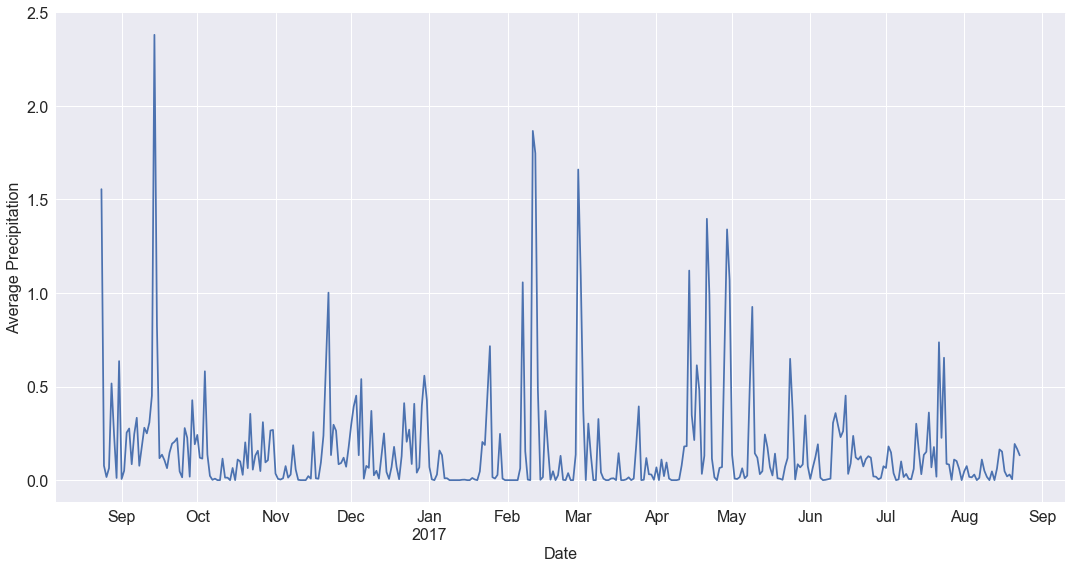

In [27]:
# Timeseries plot by a daily frequency
pptn_df2.plot(y = "mean", figsize = (15,8), legend = False)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.xlabel("Date", fontsize = 16)
plt.ylabel("Average Precipitation", fontsize = 16)
plt.tight_layout()
plt.savefig("Images/pptn.svg")

In [30]:
# Get the mean by month
pptn_df2_monthly_avg = pptn_df2.iloc[:, 0:1].resample("M").mean() 
pptn_df2_monthly_avg

,mean
date,
2016-08,0.390060
2016-09,0.280033
2016-10,0.120344
2016-11,0.130408
2016-12,0.199009
2017-01,0.075740
2017-02,0.225781
2017-03,0.157887
2017-04,0.315187


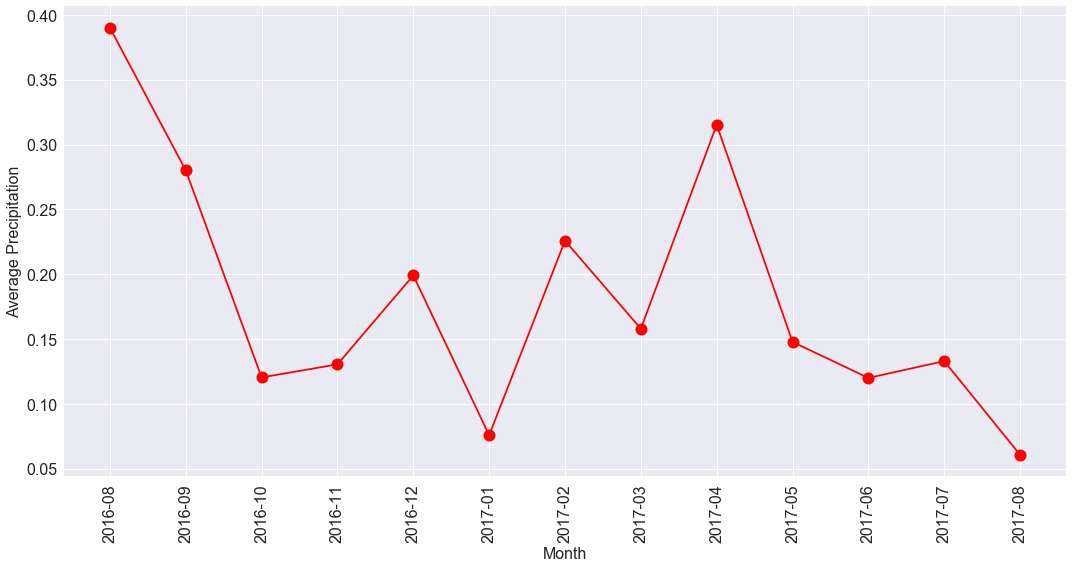

In [34]:
# Monthly precipitation averages for one year
x = np.arange(len(pptn_df2_monthly_avg.index))
y = pptn_df2_monthly_avg["mean"].values
plt.figure(figsize = (15,8))
plt.errorbar(x, y, marker = "o", markersize = 12, color = "red")
plt.ylabel("Average Precipitation", fontsize = 16)
plt.xlabel("Month", fontsize = 16)
plt.xticks(x, pptn_df2_monthly_avg.index.values, rotation = 90)
plt.tight_layout()

## Station Analysis

In [ ]:
# Design a query to show how many stations are available in this dataset


In [ ]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.


In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
